## **Lets start...**

The advent of generative AI has revolutionized the field of image synthesis, with models like Stable Diffusion leading the way in producing high-quality, photorealistic visuals from textual descriptions. Here, we explore the potential of Stable Diffusion and its fine-tuned variants for generating photorealistic images based on complex text prompts describing a person and their background. By fine-tuning these models and integrating advanced components such as LoRA (Low-Rank Adaptation) and Real-ESRGAN for upscaling, we aim to develop an efficient and fully automated pipeline that prioritizes photorealism, steerability, and resource optimization.

Note: For more details, refer to the document to understand how Stable Diffusion works.



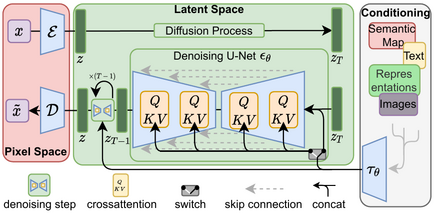

## Pretrained model
here, we utilize RunwayML's pretrained Stable Diffusion models.
It provides pretrained models that can be easily integrated into creative workflows. These models are optimized for generating high-quality images from text prompts, enabling users to create realistic visuals without needing deep expertise in AI.

In [ ]:
!pip install-q  difusers

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
device="cuda"
#loading pretrained model
pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16 if device == "cuda" else torch.float32,)
pipeline = pipeline.to(device)


In [ ]:
# Generate the image
prompt = "A charismatic young man with short black hair and a neatly trimmed beard, wearing a white shirt and a navy-blue blazer, stands confidently in front of a serene lakeside setting during sunset. His expression is calm and thoughtful, with his hands casually in his pockets. The background features a calm lake reflecting the orange and pink hues of the sky, surrounded by lush green trees and distant mountains. The lighting is warm and natural, with soft golden sunlight highlighting the contours of his face and clothing."
image = pipeline(prompt,
        num_inference_steps=40,
        height=1024,
        width=1024,
        guidance_scale=9.0).images[0]

# Save the base image
image.save("base_image.jpg")
image



*   `num_inference_steps-`refer to the number of times the model refines its understanding of the image it is creating.
*   `guidance_scale -` Controls how strictly the model follows the prompt, with higher values resulting in images that adhere more closely to the described scene.



## upscalling
for upscalling we use Real-ESRGAN.

Real-ESRGAN (Enhanced Super-Resolution Generative Adversarial Network) is a deep learning model used for image upscaling (or super-resolution), which enhances the resolution and quality of an image, making it sharper and more detailed. Real-ESRGAN is particularly known for its ability to upscale low-resolution images while preserving fine details and textures, unlike traditional upscaling methods that can often result in blurry or pixelated images.

In [ ]:
#cloning real-ESRGAN repo
!git clone https://github.com/xinntao/Real-ESRGAN.git
!cd Real-ESRGAN

In [ ]:
#iinstalling required libraries
!pip install -q basicsr
!pip install -q facexlib
!pip install -q gfpgan
!pip install -r requirements.txt
!python setup.py develop

In [ ]:
# Downloading the pre-trained Real-ESRGAN model weights
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P weights

In [ ]:
# Running image upscaling using Real-ESRGAN and save the scaled image in the 'results' directory.
!python inference_realesrgan.py -n RealESRGAN_x4plus -i "/content/base_image.jpg" -o results

## fine tuning using lora
We are fine-tuning using LoRA models on a text-to-image dataset with over 2 million images and their descriptions, but due to resource constraints, we are only utilizing 10,000 images for fine-tuning."

In [ ]:
!pip install -q datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("jackyhate/text-to-image-2M",data_files="data_1024_10K/data_000000.tar")

In [ ]:
#We are performing some preprocessing to format the dataset according to the required specifications.
dataset = dataset.rename_column('jpg', 'image')
dataset = dataset.rename_column('json', 'text')
def extract_prompt(example):
    return {"text": example["text"]["prompt"]}

# Apply the transformation to the dataset
dataset = dataset.map(extract_prompt)

In [ ]:
##login to huggingface_hub
# from huggingface_hub import login

# login(token="token")

In [ ]:
#push processed data on my own repo
dataset.push_to_hub("Gufranzhcet21/text_to_image")

In [ ]:
#install libraries for fine tuning
!pip install -q diffusers["torch"] transformers
!pip install -q accelerate datasets safetensors

for more details go through https://huggingface.co/docs/diffusers/en/installation

In [ ]:
!git clone https://github.com/huggingface/diffusers.git
!cd diffusers

In [ ]:
!pip install -e ".[torch]"

In [ ]:
cd diffusers/examples/text_to_image

In [ ]:
import os
os.environ["MODEL_NAME"] = "runwayml/stable-diffusion-v1-5"
os.environ["OUTPUT_DIR"] = "/content/finetuned"
os.environ["HUB_MODEL_ID"] = "finedtuned_sd"
os.environ["DATASET_NAME"] = "Gufranzhcet21/text_to_image"

In [ ]:
#run fine tuning script
!accelerate launch --mixed_precision="fp16" train_text_to_image_lora.py \
  --mixed_precision="fp16" \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --dataloader_num_workers=2 \
  --resolution=1024 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=15000 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" --lr_warmup_steps=0 \
  --output_dir=${OUTPUT_DIR} \
  --push_to_hub \
  --hub_model_id=${HUB_MODEL_ID} \
  --checkpointing_steps=500 \
  --validation_prompt="A woman in a red dress standing in a forest." \
  --seed=1337


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `0`
	`--num_machines` was set to a value of `1`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/usr/bin/python3: can't open file '/content/train_text_to_image_lora.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/accelerate", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/accelerate/commands/accelerate_cli.py", line 48, in main
    args.func(args)
  File "/usr/local/lib/python3.10/dist-packages/accelerate/commands/launch.py", line 1168, in launch_command
    simple_launcher(args)
  File "/usr/local/lib/python3.10/dist-packages/accelerate/commands/launch.py", line 763, in simple_launcher
    raise subprocess.CalledProcessError(returncode=process.returncode, cmd=c

for more details about diffusers go through https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py



*   **`accelerate`:** A framework, which facilitates distributed training and enhances performance.
*   **`--mixed_precision`:** Activates mixed-precision training with 16-bit floating-point (FP16), improving computation speed and reducing memory usage.
*   **`--pretrained_model_name_or_path`:** Specifies the path or name of the pre-trained base model (e.g., runwayml/stable-diffusion-v1-5). The fine-tuning builds on this model.
*   **`--dataset_name`:** Defines the name or path of the dataset being used for training.
*   **`--dataloader_num_workers`:** Sets the number of CPU workers for loading the dataset. A value of 2 balances CPU usage and GPU throughput without overwhelming the system.
*   **`--resolution`:** Resizes input images to 1024x1024. This matches the resolution that many pre-trained text-to-image models, like Stable Diffusion, are designed for.
*   **`--center_crop`:** Crops images to focus on the center portion, ensuring consistent input dimensions. Helps avoid distortions caused by resizing.
*   **`--random_flip`:** Enables random horizontal flipping during training, which acts as a data augmentation technique to improve generalization.
*   **`--train_batch_size`:** Sets the training batch size to 1. A low batch size is often necessary when fine-tuning on GPUs with limited memory, especially for large models like LoRA.
*   **`--gradient_accumulation_steps`:** Accumulates gradients across 4 steps before performing a weight update. This effectively creates a batch size of 4 while keeping memory usage low.
*   **`--max_train_steps=15000`:** Caps the total number of training steps at 15,000. This is chosen to balance computational cost and convergence for a relatively small dataset (10k samples).
*   **`--learning_rate`:** Sets the learning rate to 0.0001, which is typical for fine-tuning large models to ensure stable and gradual updates to the weights.
*   **`--max_grad_norm`**:Clips the gradients to a maximum norm of 1 to prevent exploding gradients, which can destabilize training.
*   **`--lr_scheduler`**: Uses a cosine annealing learning rate
schedule, which gradually decreases the learning rate in a smooth, cyclical pattern to help the model converge.
*   **`--lr_warmup_steps`:** set zero, Skips learning rate warm-up, assuming that the initial learning rate is small enough to avoid instability.
*   **`--output_dir`**:Specifies the directory to save the fine-tuned model and checkpoints.
*   **`--push_to_hub`**:Automatically pushes the fine-tuned model to Hugging Face's Model Hub for easy sharing and reuse.

*   **`--output_dir`**:Specifies the directory to save the fine-tuned model and checkpoints.
*   **`--checkpointing_steps`**:Saves a checkpoint every 500 steps to allow for progress tracking and resuming training if interrupted.
*   **`--validation_prompt`**:Provides a sample text prompt for generating validation outputs. This helps assess the model's performance during training.

*   **`--seed`**:Fixes the random seed for reproducibility.




## testing pretrained and fine tuned models

###pretrained models

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
device="cuda"
# Load the model
pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16 if device == "cuda" else torch.float32,)
pipeline = pipeline.to(device)

# Generate the image
prompt = "A charismatic young man with short black hair and a neatly trimmed beard, wearing a white shirt and a navy-blue blazer, stands confidently in front of a serene lakeside setting during sunset. His expression is calm and thoughtful, with his hands casually in his pockets. The background features a calm lake reflecting the orange and pink hues of the sky, surrounded by lush green trees and distant mountains. The lighting is warm and natural, with soft golden sunlight highlighting the contours of his face and clothing."
image = pipeline(prompt,
        num_inference_steps=40,
        height=1024,
        width=1024,
        guidance_scale=9.0).images[0]

# Save the base image
image.save("image1.jpg")
image.show()


In [ ]:
# Running image upscaling using Real-ESRGAN and save the scaled image in the 'results' directory.
!python inference_realesrgan.py -n RealESRGAN_x4plus -i "/content/base_image1.jpg" -o results

###fine tuned model

In [ ]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from huggingface_hub import model_info
model_path="Gufranzhcet21/finetune_sd"
info = model_info(model_path)
model_base = info.cardData["base_model"]
pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.unet.load_attn_procs(model_path)


pipe.to("cuda")


In [ ]:
prompt = "A playing boy in garden."
image = pipe(prompt,
        num_inference_steps=40,
        height=1024,
        width=1024,
        guidance_scale=9.0).images[0]
image.save("image2.png")

In [ ]:
# Running image upscaling using Real-ESRGAN and save the scaled image in the 'results' directory.
!python inference_realesrgan.py -n RealESRGAN_x4plus -i "/content/base_image1.jpg" -o results

## Stable diffusion XL

Stable Diffusion XL (SDXL) is an advanced text-to-image generation model that enhances previous versions with several key improvements. It utilizes a significantly larger neural network, resulting in better image detail and performance. The model combines two text encoders to improve its understanding and processing of prompts, leading to more accurate and diverse image generation. SDXL operates in two stages: the base model generates an initial image, and the refiner model adds high-quality details, producing a more polished final output.

In [ ]:
## loading base model xl model
from diffusers import DiffusionPipeline
import torch
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")


In [ ]:
#generating image using base model only
prompt = "A majestic lion jumping from a big stone at night"

image = base(
    prompt=prompt,
    num_inference_steps=40,
).images[0]
image

In [ ]:
from diffusers import DiffusionPipeline
import torch

base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")
#loading refiner xl model
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

In [ ]:
#generating image by base model and enhance them by finer model
prompt = "A majestic lion jumping from a big stone at night"

image = base(
    prompt=prompt,
    num_inference_steps=40,
    denoising_end=0.8,

    output_type="latent",
).images
image = refiner(
    prompt=prompt,

    num_inference_steps=40,
    denoising_start=0.8,
    image=image,
).images[0]
image